In [14]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

In [15]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [16]:
# now let get all the information for stock
stock =  read_csv('BABA20130425_20180425.csv', header=0)
print(stock.shape)
print(stock.head())

(905, 7)
         Date       Open       High        Low      Close  Adj Close  \
0  2014-09-19  92.699997  99.699997  89.949997  93.889999  93.889999   
1  2014-09-22  92.699997  92.949997  89.500000  89.889999  89.889999   
2  2014-09-23  88.940002  90.480003  86.620003  87.169998  87.169998   
3  2014-09-24  88.470001  90.570000  87.220001  90.570000  90.570000   
4  2014-09-25  91.089996  91.500000  88.500000  88.919998  88.919998   

      Volume  
0  271879400  
1   66657800  
2   39009800  
3   32088000  
4   28598000  


In [17]:
# now get the stock close price
# astype means "Copy of the array, cast to a specified type."
stock_prices = stock.Close.values.astype("float32")
shape0=stock_prices.shape[0]
stock_prices = stock_prices.reshape(shape0, 1)
print(stock_prices.shape)
# print the prices of last five observations
print(stock_prices[-5:])

(905, 1)
[[ 182.67999268]
 [ 181.38999939]
 [ 179.11000061]
 [ 175.57000732]
 [ 173.08999634]]


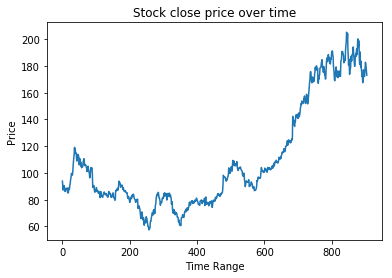

In [18]:
# Before doing any analysis, first plot the prices series(data)
pyplot.plot(stock_prices)
pyplot.title('Stock close price over time')
pyplot.ylabel('Price')
pyplot.xlabel('Time Range')
pyplot.show()

In [19]:
# now get the stock Volume
# astype means "Copy of the array, cast to a specified type."
stock_volumes = stock.Volume.values.astype("float32")
shape0=stock_volumes.shape[0]
stock_volumes = stock_volumes.reshape(shape0, 1)
print(stock_volumes.shape)
# print the volumes of last five observations
print(stock_volumes[-5:])

(905, 1)
[[ 16972700.]
 [ 11989000.]
 [ 14473100.]
 [ 12033900.]
 [ 14340100.]]


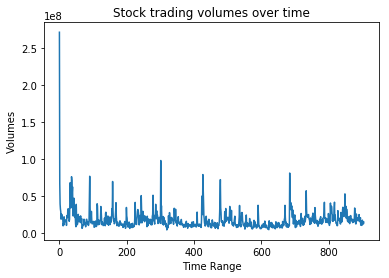

In [20]:
# Before doing any analysis, first plot the volumes series(data)
pyplot.plot(stock_volumes)
pyplot.title('Stock trading volumes over time')
pyplot.ylabel('Volumes')
pyplot.xlabel('Time Range')
pyplot.show()

In [21]:
values = concatenate((stock_prices, stock_volumes), axis=1)

In [22]:
# check the last five observations to make sure it's correct
print(values[-5:, :])

[[  1.82679993e+02   1.69727000e+07]
 [  1.81389999e+02   1.19890000e+07]
 [  1.79110001e+02   1.44731000e+07]
 [  1.75570007e+02   1.20339000e+07]
 [  1.73089996e+02   1.43401000e+07]]


In [23]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
# var1 means prices, var2 means volumns

   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1   0.246905   1.000000  0.219847  0.234545
2   0.219847   0.234545  0.201448  0.131421
3   0.201448   0.131421  0.224447  0.105603
4   0.224447   0.105603  0.213286  0.092586
5   0.213286   0.092586  0.223703  0.054325


In [24]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)
1   0.246905   1.000000  0.219847
2   0.219847   0.234545  0.201448
3   0.201448   0.131421  0.224447
4   0.224447   0.105603  0.213286
5   0.213286   0.092586  0.223703


In [25]:
# split into train and test sets
values = reframed.values
n_train = int(reframed.shape[0] * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(723, 1, 2) (723,) (181, 1, 2) (181,)


In [26]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 723 samples, validate on 181 samples
Epoch 1/300
0s - loss: 0.2328 - val_loss: 0.8140
Epoch 2/300
0s - loss: 0.1891 - val_loss: 0.7486
Epoch 3/300
0s - loss: 0.1478 - val_loss: 0.6834
Epoch 4/300
0s - loss: 0.1127 - val_loss: 0.6198
Epoch 5/300
0s - loss: 0.0924 - val_loss: 0.5666
Epoch 6/300
0s - loss: 0.0881 - val_loss: 0.5325
Epoch 7/300
0s - loss: 0.0875 - val_loss: 0.5112
Epoch 8/300
0s - loss: 0.0867 - val_loss: 0.4962
Epoch 9/300
0s - loss: 0.0863 - val_loss: 0.4848
Epoch 10/300
0s - loss: 0.0855 - val_loss: 0.4740
Epoch 11/300
0s - loss: 0.0827 - val_loss: 0.4638
Epoch 12/300
0s - loss: 0.0817 - val_loss: 0.4534
Epoch 13/300
0s - loss: 0.0807 - val_loss: 0.4432
Epoch 14/300
0s - loss: 0.0774 - val_loss: 0.4336
Epoch 15/300
0s - loss: 0.0774 - val_loss: 0.4244
Epoch 16/300
0s - loss: 0.0745 - val_loss: 0.4131
Epoch 17/300
0s - loss: 0.0722 - val_loss: 0.4011
Epoch 18/300
0s - loss: 0.0721 - val_loss: 0.3906
Epoch 19/300
0s - loss: 0.0703 - val_loss: 0.3799
Epoch 20/300


0s - loss: 0.0138 - val_loss: 0.0461
Epoch 165/300
0s - loss: 0.0137 - val_loss: 0.0384
Epoch 166/300
0s - loss: 0.0143 - val_loss: 0.0342
Epoch 167/300
0s - loss: 0.0145 - val_loss: 0.0332
Epoch 168/300
0s - loss: 0.0139 - val_loss: 0.0266
Epoch 169/300
0s - loss: 0.0134 - val_loss: 0.0286
Epoch 170/300
0s - loss: 0.0142 - val_loss: 0.0261
Epoch 171/300
0s - loss: 0.0143 - val_loss: 0.0314
Epoch 172/300
0s - loss: 0.0155 - val_loss: 0.0325
Epoch 173/300
0s - loss: 0.0140 - val_loss: 0.0313
Epoch 174/300
0s - loss: 0.0142 - val_loss: 0.0215
Epoch 175/300
0s - loss: 0.0138 - val_loss: 0.0205
Epoch 176/300
0s - loss: 0.0147 - val_loss: 0.0205
Epoch 177/300
0s - loss: 0.0144 - val_loss: 0.0218
Epoch 178/300
0s - loss: 0.0144 - val_loss: 0.0210
Epoch 179/300
0s - loss: 0.0131 - val_loss: 0.0250
Epoch 180/300
0s - loss: 0.0145 - val_loss: 0.0248
Epoch 181/300
0s - loss: 0.0139 - val_loss: 0.0270
Epoch 182/300
0s - loss: 0.0150 - val_loss: 0.0207
Epoch 183/300
0s - loss: 0.0147 - val_loss: 0

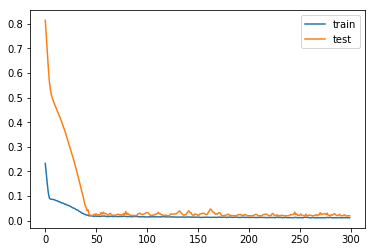

In [27]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [28]:
# make a prediction for train data
yhat_train = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat_train = concatenate((yhat_train, train_X[:, 1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 1.857


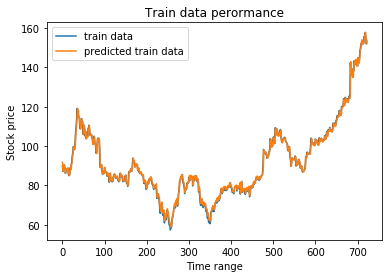

In [29]:
# plot only the train data and predicted train data
trainline, =pyplot.plot(inv_y_train, label='train data')  # blue one
trainPredictline, =pyplot.plot(inv_yhat_train, label='predicted train data') # orange one
pyplot.title("Train data perormance")
pyplot.ylabel('Stock price')
pyplot.xlabel('Time range')
pyplot.legend(handles=[trainline, trainPredictline])
pyplot.show()

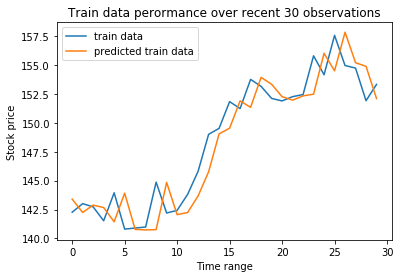

In [30]:
# plot only the last 100 train data and predicted train data
trainline, =pyplot.plot(inv_y_train[-30:], label='train data')  # blue one
trainPredictline, =pyplot.plot(inv_yhat_train[-30:], label='predicted train data') # orange one
pyplot.title("Train data perormance over recent 30 observations")
pyplot.ylabel('Stock price')
pyplot.xlabel('Time range')
pyplot.legend(handles=[trainline, trainPredictline])
pyplot.show()

In [31]:
# check some observations of train data
print(inv_y_train.shape)
print(inv_yhat_train.shape)
# check the performance
print(inv_y_train[-1])
print(inv_yhat_train[-1])
#
print(inv_y_train[-2])
print(inv_yhat_train[-2])
#
print(inv_y_train[-3])
print(inv_yhat_train[-3])
#
print(inv_y_train[-4])
print(inv_yhat_train[-4])

(723,)
(723,)
153.32
152.095
151.91
154.88
154.73
155.194
154.95
157.827


The largest absolute difference for train data: 17.07


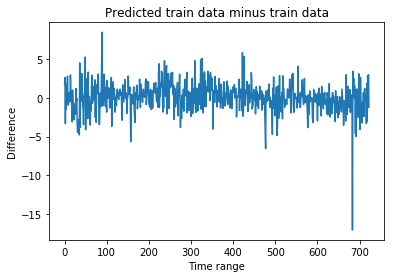

In [32]:
# plot the difference for train data
traindiff = inv_yhat_train - inv_y_train
#
maxtraindiff=abs(max(traindiff, key=abs))
print('The largest absolute difference for train data: %.2f' % (maxtraindiff))
#
pyplot.plot(traindiff)
#
pyplot.title("Predicted train data minus train data")
pyplot.ylabel('Difference')
pyplot.xlabel('Time range')
pyplot.show()

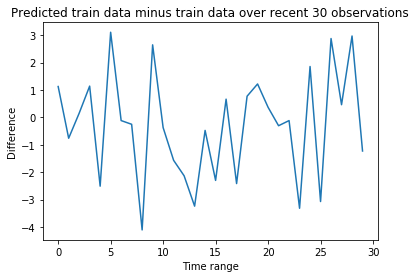

In [33]:
# plot the difference for the recent 30 obs of train data
pyplot.plot(traindiff[-30:])
#
pyplot.title("Predicted train data minus train data over recent 30 observations")
pyplot.ylabel('Difference')
pyplot.xlabel('Time range')
pyplot.show()

In [34]:
# make a prediction for test data
yhat_test = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat_test = concatenate((yhat_test, test_X[:, 1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_test = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.936


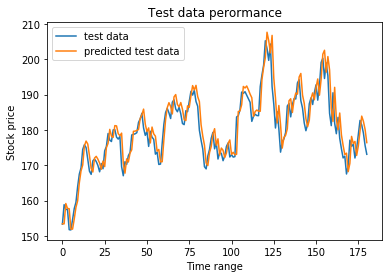

In [35]:
# plot only the test data and predicted test data
testline, =pyplot.plot(inv_y_test, label='test data')  # blue one
testPredictline, =pyplot.plot(inv_yhat_test, label='predicted test data') # orange one
pyplot.title("Test data perormance")
pyplot.ylabel('Stock price')
pyplot.xlabel('Time range')
pyplot.legend(handles=[testline, testPredictline])
pyplot.show()

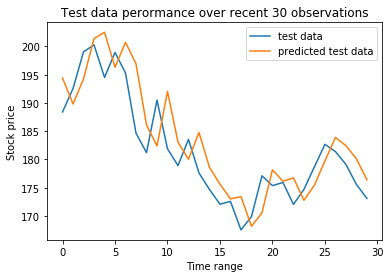

In [36]:
# plot only the last 30 test data and predicted test data
testline, =pyplot.plot(inv_y_test[-30:], label='test data')  # blue one
testPredictline, =pyplot.plot(inv_yhat_test[-30:], label='predicted test data') # orange one
pyplot.title("Test data perormance over recent 30 observations")
pyplot.ylabel('Stock price')
pyplot.xlabel('Time range')
pyplot.legend(handles=[testline, testPredictline])
pyplot.show()

In [37]:
# check some observations of test data
print(inv_y_test.shape)
print(inv_yhat_test.shape)
# check the performance
print(inv_y_test[-1])
print(inv_yhat_test[-1])
#
print(inv_y_test[-2])
print(inv_yhat_test[-2])
#
print(inv_y_test[-3])
print(inv_yhat_test[-3])
#
print(inv_y_test[-4])
print(inv_yhat_test[-4])

(181,)
(181,)
173.09
176.397
175.57
180.124
179.11
182.44
181.39
183.891


The largest absolute difference for test data: 14.51


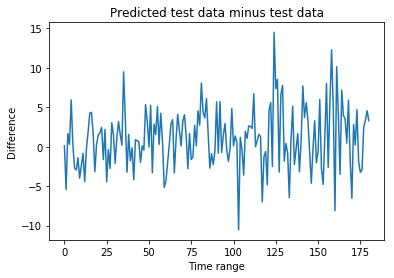

In [38]:
# plot the difference for test data
testdiff = inv_yhat_test - inv_y_test
#
maxtestdiff=abs(max(testdiff, key=abs))
print('The largest absolute difference for test data: %.2f' % (maxtestdiff))
#
pyplot.plot(testdiff)
#
pyplot.title("Predicted test data minus test data")
pyplot.ylabel('Difference')
pyplot.xlabel('Time range')
pyplot.show()

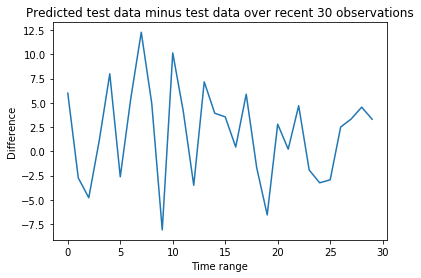

In [39]:
# plot the difference for the recent 30 obs of test data
pyplot.plot(testdiff[-30:])
#
pyplot.title("Predicted test data minus test data over recent 30 observations")
pyplot.ylabel('Difference')
pyplot.xlabel('Time range')
pyplot.show()